# `dtreeviz` TensorFlow Decision Forests Examples

([View this notebook in Colab](https://colab.research.google.com/github/parrt/dtreeviz/blob/master/notebooks/dtreeviz_tensorflow_visualisations.ipynb))

The [dtreeviz](https://github.com/parrt/dtreeviz) library is designed to help machine learning practitioners visualize and interpret decision trees and decision-tree-based models, such as gradient boosting machines.  

The purpose of this notebook is to illustrate the main capabilities and functions of the dtreeviz API. To do that, we will use TensorFlow Decision Forests and the toy but well-known Titanic data set for illustrative purposes.  Currently, dtreeviz supports the following decision tree libraries:

* [scikit-learn](https://scikit-learn.org/stable)
* [XGBoost](https://xgboost.readthedocs.io/en/latest)
* [Spark MLlib](https://spark.apache.org/mllib/)
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/)
* [Tensorflow](https://www.tensorflow.org/decision_forests)

To interopt with these different libraries, dtreeviz uses an adaptor object, obtained from function `dtreeviz.model()`, to extract model information necessary for visualization. Given such an adaptor object, all of the dtreeviz functionality is available to you using the same programmer interface. The basic dtreeviz usage recipe is:

1. Import dtreeviz and your decision tree library
2. Acquire and load data into memory
3. Train a classifier or regressor model using your decision tree library
4. Obtain a dtreeviz adaptor model using<br>`viz_model = dtreeviz.model(your_trained_model,...)`
5. Call dtreeviz functions, such as<br>`viz_model.view()` or `viz_model.explain_prediction_path(sample_x)`

The four categories of dtreeviz functionality are:

1. Tree visualizations
2. Prediction path explanations
3. Leaf information
4. Feature space exploration

We have grouped code examples by [classifiers](#Classifiers) and [regressors](#Regressors), with a follow up section on [partitioning feature space](#Feature-Space-Partitioning).

*These examples require dtreeviz 2.0 or above because the code uses the new API introduced in 2.0.*

## Setup

In [2]:
import sys

In [3]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz
  !pip install -q tensorflow_decision_forests

In [4]:
import tensorflow_decision_forests as tf
from tensorflow_decision_forests.tensorflow.core import Task

from sklearn.model_selection import train_test_split

import pandas as pd
from collections import defaultdict

import dtreeviz

random_state = 1234 # get reproducible trees

## Load Sample Data

In [5]:
random_state = 1234
dataset_url = "https://raw.githubusercontent.com/parrt/dtreeviz/master/data/titanic/titanic.csv"
dataset = pd.read_csv(dataset_url)
# Fill missing values for Age
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes

dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes


# Classifiers

To demonstrate classifier decision trees, we trying to model using six features to predict the boolean survived target.

In [6]:
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

dataset_tf = tf.keras.pd_dataframe_to_tf_dataset(dataset[features + [target]], label=target)
model = tf.keras.RandomForestModel(num_trees=1, max_depth=4, random_seed = random_state)
model.fit(dataset_tf)

Use /var/folders/yp/rczwnkhn6nn9mfcf0bgc61jh0000gn/T/tmpmlvv7c19 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.457054. Found 891 examples.
Training model...
Model trained in 0:00:00.032557
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


## Initialize dtreeviz model (adaptor)

To adapt dtreeviz to a specific model, use the `model()` function to get an adaptor.  You'll need to provide the model, X/y data, feature names, target name, and target class names:

In [7]:
viz_model = dtreeviz.model(model, tree_index=0, 
                             X_train=dataset[features], 
                             y_data=dataset[target], 
                             feature_names=features, 
                             target_name=target,
                             class_names=["survive", "perish"])

We'll use this model to demonstrate dtreeviz functionality in the following sections; the code will look the same for any decision tree library once we have this model adaptor.

## Tree structure visualizations
To show the decision tree structure using the default visualization, call `view()`:

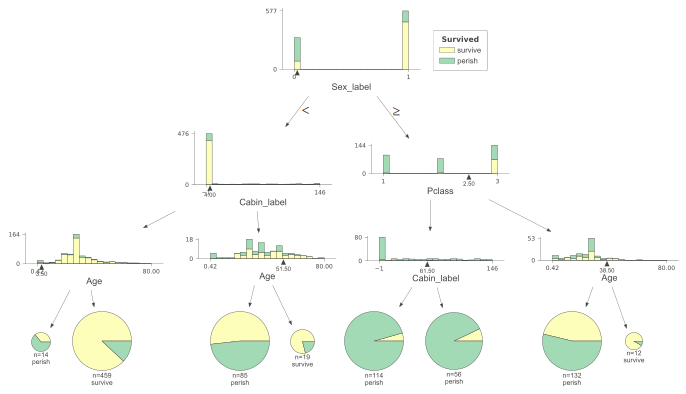

In [12]:
viz_model.view()

To change the visualization, you can pass parameters, such as changing the orientation to left-to-right:

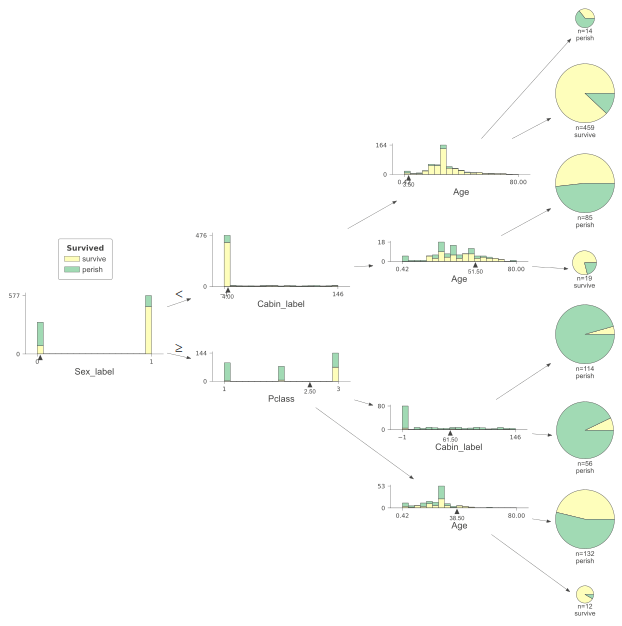

In [13]:
viz_model.view(orientation="LR")

To visualize larger trees, you can reduce the amount of detail by turning off the fancy view:

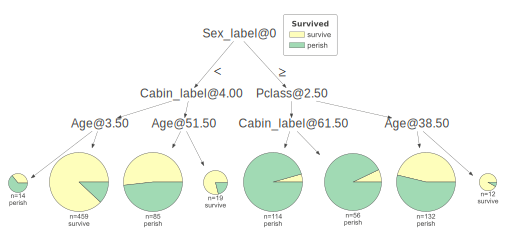

In [14]:
viz_model.view(fancy=False)

Another way to reduce the visualization size is to specify the tree depths of interest:

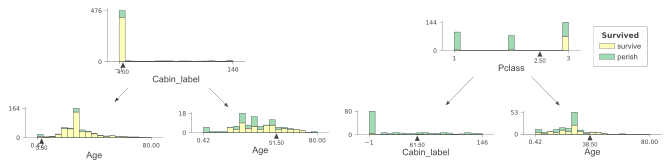

In [15]:
viz_model.view(depth_range_to_display=(1, 2)) # root is level 0

## Prediction path explanations

For interpretation purposes, we often want to understand how a tree behaves for a specific instance. Let's pick a specific instance:

In [16]:
x = dataset[features].iloc[10]
x

Pclass              3.0
Age                 4.0
Fare               16.7
Sex_label           0.0
Cabin_label       145.0
Embarked_label      2.0
Name: 10, dtype: float64

and then display the path through the tree structure:

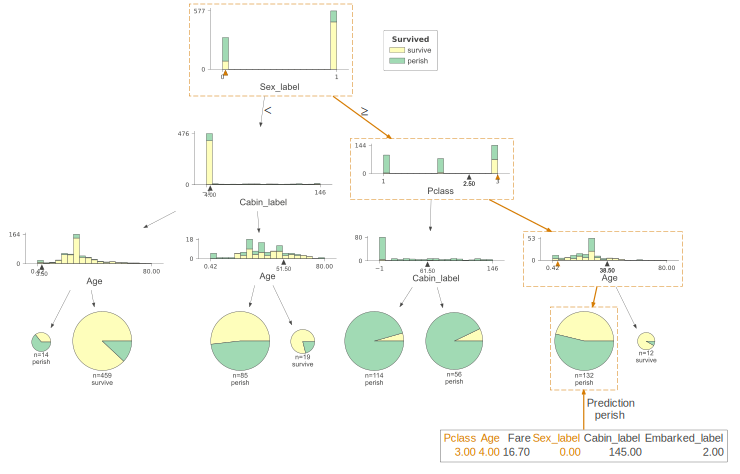

In [17]:
viz_model.view(x=x)

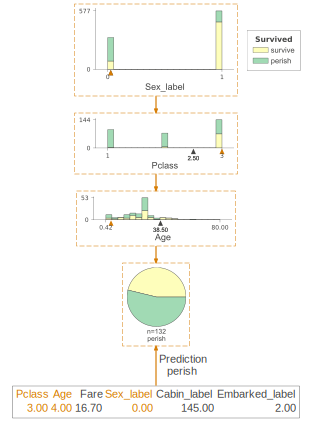

In [18]:
viz_model.view(x=x, show_just_path=True)

You can also get a string representation explaining the comparisons made as an instance is run down the tree:

In [19]:
print(viz_model.explain_prediction_path(x))

2.5 <= Pclass 
Age < 38.5
Sex_label in {0}  



## Leaf info

There are a number of functions to get information about the leaves of the tree.

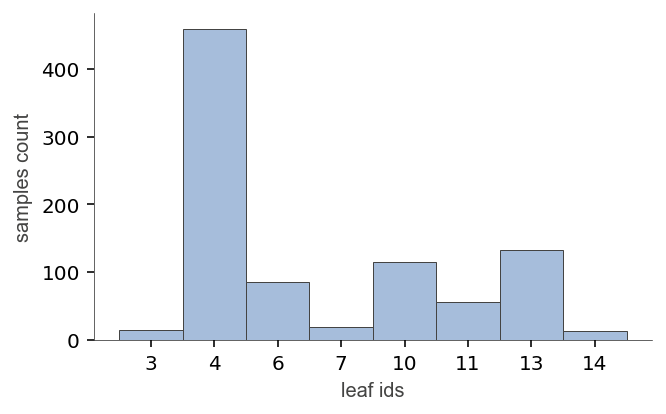

In [20]:
viz_model.leaf_sizes()

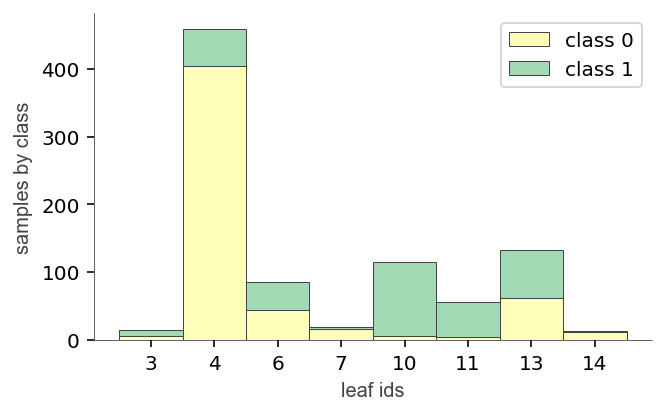

In [21]:
viz_model.ctree_leaf_distributions()

In [22]:
viz_model.node_stats(node_id=4)

Pclass         Age        Fare  Sex_label  Cabin_label  \
count  459.000000  459.000000  459.000000      459.0   459.000000   
mean     2.657952   29.773855   16.041310        1.0    -0.984749   
std      0.597115   10.872936   18.720447        0.0     0.213585   
min      1.000000    4.000000    0.000000        1.0    -1.000000   
25%      2.000000   23.000000    7.775000        1.0    -1.000000   
50%      3.000000   29.699118    8.404200        1.0    -1.000000   
75%      3.000000   32.250000   16.000000        1.0    -1.000000   
max      3.000000   74.000000  227.525000        1.0     3.000000   

       Embarked_label  
count      459.000000  
mean         1.647059  
std          0.706834  
min          0.000000  
25%          2.000000  
50%          2.000000  
75%          2.000000  
max          2.000000

# Regressors

To demonstrate regressor tree visualization, we start by creating a regressors model that predicts age instead of survival:

In [23]:
features_reg = ["Pclass", "Fare", "Sex_label", "Cabin_label", "Embarked_label", "Survived"]
target_reg = "Age"

dataset_rtf = tf.keras.pd_dataframe_to_tf_dataset(dataset[features_reg + [target_reg]], label = target_reg, task=Task.REGRESSION)

model_reg = tf.keras.RandomForestModel(num_trees=4, max_depth=4, random_seed = random_state, bootstrap_training_dataset=False, sampling_with_replacement=False, task=Task.REGRESSION)
model_reg.fit(dataset_rtf)




Use /var/folders/yp/rczwnkhn6nn9mfcf0bgc61jh0000gn/T/tmpe_a0avnq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.169245. Found 891 examples.
Training model...
Model trained in 0:00:00.014432
Compiling model...
Model compiled.


## Initialize dtreeviz model (adaptor)

In [24]:
viz_rmodel = dtreeviz.model(model_reg, tree_index=0, 
                             X_train=dataset[features_reg], 
                             y_data=dataset[target_reg], 
                             feature_names=features_reg, 
                             target_name=target_reg)

## Tree structure visualisations

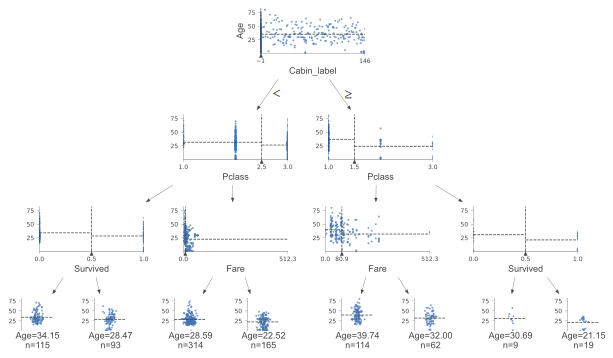

In [25]:
viz_rmodel.view()

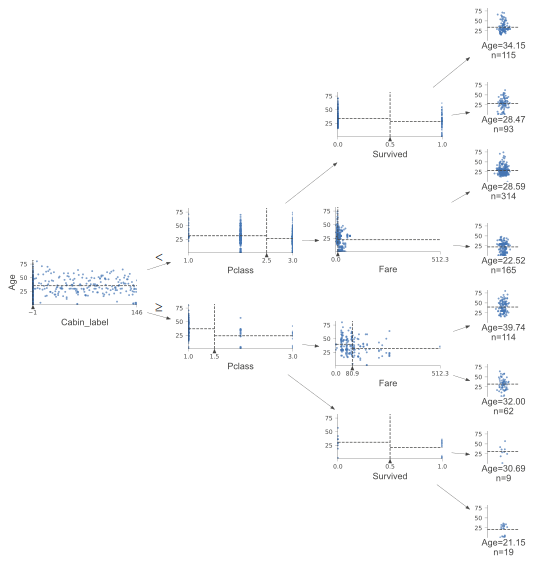

In [26]:
viz_rmodel.view(orientation="LR")

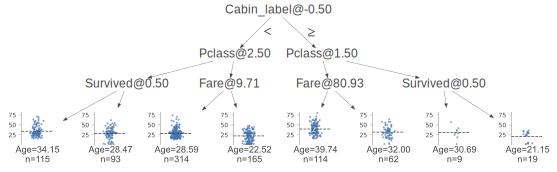

In [27]:
viz_rmodel.view(fancy=False)

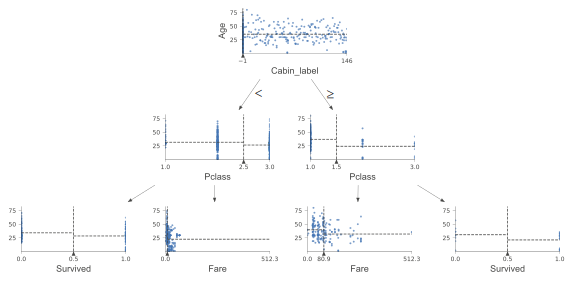

In [28]:
viz_rmodel.view(depth_range_to_display=(0, 2))

## Prediction path explanations

In [29]:
x = dataset[features_reg].iloc[10]
x

Pclass              3.0
Fare               16.7
Sex_label           0.0
Cabin_label       145.0
Embarked_label      2.0
Survived            1.0
Name: 10, dtype: float64

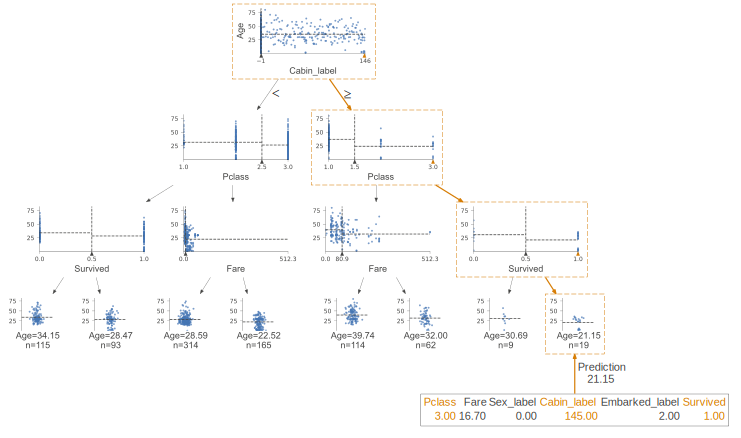

In [30]:
viz_rmodel.view(x = x)

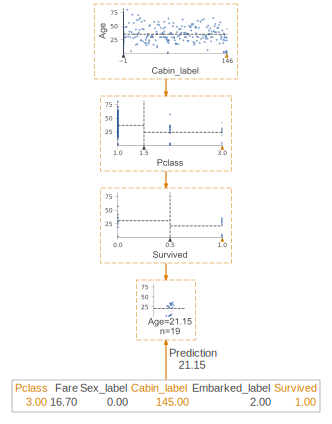

In [31]:
viz_rmodel.view(show_just_path=True, x = x)

In [32]:
print(viz_rmodel.explain_prediction_path(x))

1.5 <= Pclass 
-0.5 <= Cabin_label 
0.5 <= Survived 



## Leaf info

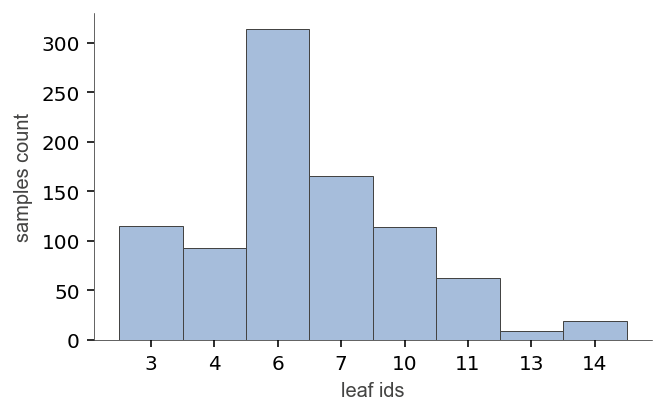

In [33]:
viz_rmodel.leaf_sizes()

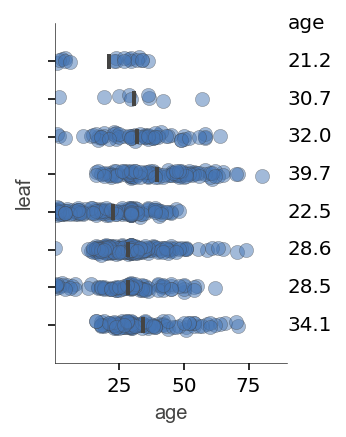

In [34]:
viz_rmodel.rtree_leaf_distributions()

In [35]:
viz_rmodel.node_stats(node_id=6)

Pclass        Fare   Sex_label  Cabin_label  Embarked_label    Survived
count   314.0  314.000000  314.000000        314.0      314.000000  314.000000
mean      3.0    7.745526    0.808917         -1.0        1.595541    0.207006
std       0.0    1.078506    0.393782          0.0        0.691421    0.405807
min       3.0    0.000000    0.000000         -1.0        0.000000    0.000000
25%       3.0    7.550000    1.000000         -1.0        1.000000    0.000000
50%       3.0    7.854200    1.000000         -1.0        2.000000    0.000000
75%       3.0    8.050000    1.000000         -1.0        2.000000    0.000000
max       3.0    9.587500    1.000000         -1.0        2.000000    1.000000

# Feature Space Partitioning

Decision trees partition feature space in such a way as to maximize target value purity for the instances associated with a node. It's often useful to visualize the feature space partitioning, although it's not feasible to visualize more than a couple of dimensions.

*work in progress for this library*

See [Feature Space Partitioning for scikit-learn](dtreeviz_sklearn_visualisations.ipynb#Feature_Space_Partitioning) for now.